In [63]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from numpy.random import RandomState
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import os
import re
pd.set_option('display.max_colwidth', -1)

In [2]:
os.getcwd()

'/Users/yiweiluo/scientific-debates/cc_stance/data_creation'

In [3]:
#labeled_data = pd.read_csv('./tweet-stance-prediction/data/labeled_data_df')
labeled_data = pd.read_pickle('./data/labeled_data_df.pkl')
#{'source':[],'type':[],'text':[],'stance':[]}
#unlabeled_data = {'source':[],'type':[],'text':[]}

In [5]:
labeled_data.shape

(678485, 4)

In [6]:
labeled_data.type.value_counts()

twint_tweet              520886
dallas_news_predicted    114686
dallas_news              40309 
mturk                    2040  
semeval_train_tweets     395   
semeval_tweets           169   
Name: type, dtype: int64

In [7]:
labeled_data.columns

Index(['source', 'type', 'text', 'stance'], dtype='object')

In [8]:
labeled_data = labeled_data[['source','type','text','stance']]

# Comp clauses w/ +/- 2 sentence window

In [169]:
from nltk.tokenize import sent_tokenize

In [145]:
# Load dataframe 
all_url_df = pd.read_pickle("/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/\
all_urls_meta_and_fulltext_df_2020.pkl")
all_urls = list(all_url_df['url'])
all_urls_set = set(all_urls)
print(len(all_urls))

22639


In [147]:
cc_df = all_url_df.loc[(all_url_df['topic']=='cc') & (all_url_df['bad NYT']==False)]

In [347]:
#cc_sent_tokens_by_url = {}
# for ix,url in enumerate(cc_df.url):
#     ft = cc_df.loc[cc_df.url == url]['fulltext'].values[0]
#     if ft is not None and len(ft) > 0:
#         sent_tokens = sent_tokenize(ft)
#         cc_sent_tokens_by_url[url] = sent_tokens
#     else:
#         cc_sent_tokens_by_url[url] = []
        
#     if ix % 1000 == 0:
#         print(ix)

In [348]:
#pickle.dump(cc_sent_tokens_by_url,open('tokenized_cc_fulltexts.pkl','wb'))

In [159]:
pro_cc_tuples = pickle.load(
           open('/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/\
pro_cc_tuples_verb_subject_iq_filtered.pkl','rb'))
anti_cc_tuples = pickle.load(
           open('/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/\
anti_cc_tuples_verb_subject_iq_filtered.pkl','rb'))

In [225]:
def get_url_from_tup(tup):
    res = tup[-1]
    split_res = res.split(' of ')
    url = split_res[-1]
    sent_no = split_res[0].split('sent_no_')[-1]
    return (url,sent_no)

def get_url_from_sent_key(x):
    split_res = x.split(' of ')
    url = split_res[-1]
    sent_no = split_res[0].split('sent_no_')[-1]
    return (url,sent_no)

In [258]:
def get_fulltext(tup):
    url,sent_no = get_url_from_tup(tup)
    fulltext = cc_df.loc[cc_df.url == url]['fulltext'].values[0]
    return fulltext

def get_fulltext_from_sent_key(x):
    url,sent_no = get_url_from_sent_key(x)
    ft = cc_df.loc[cc_df.url == url]['fulltext'].values[0]
    return ft

In [318]:
def get_window_from_tup(tup):
    url,sent_no = get_url_from_tup(tup)
    sent_no = int(sent_no)-1
    sent_tokens = cc_sent_tokens_by_url[url]
    if len(sent_tokens) > 0:
        start = max(sent_no-3,0)
        end = min(sent_no+2,len(sent_tokens))
        #print('preceding:',sent_tokens[start:sent_no-1])
        #print('postceding:',sent_tokens[sent_no:end])
        return sent_tokens[start:sent_no-1]+sent_tokens[sent_no:end]
    else:
        print('Empty article text')
        
def get_window(round_no,batch_no,sent_id):
    sent_tokens = sent_tokenize(get_fulltext_from_sent_key(get_orig_meta(round_no,batch_no,
                                                                         sent_id)\
                                                       ['sent_key']))
    #print(sent_tokens)
    if len(sent_tokens) > 0:
        center_sent = mturk_labeled_data.loc[mturk_labeled_data.source == 'round{}_batch{}\
_sentid{}'.format(round_no,batch_no,sent_id)]['text'].values[0]
        #print(center_sent)
        ix_center_sent = -1
        for ix,s in enumerate(sent_tokens):
            if center_sent[1:-1] in s:
                ix_center_sent = ix
                break
        #print(ix_center_sent)
        if ix_center_sent == -1:
            print('Sentence not found!')
            return None
        else:
            #print(sent_tokens[ix_center_sent])
            window_start = max(0,ix_center_sent-2)
            window_end = min(len(sent_tokens),ix_center_sent+3)
            #print('Preceding:',sent_tokens[window_start:ix_center_sent])
            #print('Post-ceding:',sent_tokens[ix_center_sent+1:window_end])
            return (sent_tokens[window_start:ix_center_sent],
                   sent_tokens[ix_center_sent+1:window_end])
    else:
        print('Empty article text')

## Create train data from expanded windows for labeled MTurk

In [207]:
mturk_labeled_data = labeled_data[labeled_data.type=='mturk']

In [210]:
data_for_mturk_df = pd.read_pickle('/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/\
data_for_mturk_2020.pkl')
data_for_mturk_df_old = pd.read_pickle('/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/\
data_for_mturk.pkl')

In [216]:
all_round_data = {r: {} for r in range(1,6)}
for round_no in range(1,6):
    all_round_data[round_no] = pickle.load(open('/Users/yiweiluo/Dropbox/research/QP2/code/Fox_and_friends/\
LIVE_ROUND{}_BATCH_DATA.pkl'.format(round_no),'rb'))

In [351]:
def get_df_index(round_id,batch_id,sent_id):
    data = pd.DataFrame(all_round_data[round_id][batch_id])
    
    #print(data)
    row = data.loc[data.sent_id == sent_id]
    #print(row)
    return row['df_key']

def get_orig_meta(round_id,batch_id,sent_id):
    df_key = get_df_index(round_id,batch_id,sent_id)
    if round_id <= 4:
        df = data_for_mturk_df_old
    else:
        df = data_for_mturk_df
    row = df.iloc[df_key]
    #print(row['subject'].value)
    return {'subj':row['subject'].values[0].lower(),
           'neg':row['negation'].values[0],
           'verb':row['verb'].values[0].lower(),
           'outlet_bias':row['bias'].values[0],
           'sent_key':row['sent_key'].values[0]} 

def get_stance(round_id,batch_id,sent_id):
    row = sent_scores.loc[(sent_scores['round']==round_id) & (sent_scores['sent_id'] == sent_id)
               & (sent_scores['batch']==batch_id)]
    return row['max_prob_label'].values[0]

def clean_space(text):
    return re.sub('\s+',' ',text)

In [309]:
get_window(1,0,'t25')

(['President Trump has said nothing about it.',
  '[The New York Times] • More than 40 governments around the world, including California, have put a price on carbon.'],
 ['[The New York Times] • The two candidates for governor — Gavin Newsom and John Cox — met for their only scheduled debate.',
  'Here’s what we learned.'])

In [323]:
# Concatenate preceding window + comp clause + post-ceding window for each train example
# train_ex = []
# unfound_sents = []
# for source in mturk_labeled_data.source:
#     fields = source.split('_')
#     round_no = int(fields[0].split('round')[-1])
#     batch_no = int(fields[1].split('batch')[-1])
#     sent_id = fields[2].split('sentid')[-1]
#     stance = mturk_labeled_data.loc[mturk_labeled_data.source == source]['stance'].values[0]
#     center = mturk_labeled_data.loc[mturk_labeled_data.source == source]['text'].values[0]
#     window = get_window(round_no,batch_no,sent_id)
#     if window is not None:
#         ex = window[0]+[center]+window[1]
#         ex = ' '.join(ex)
#         print(ex)
#         train_ex.append((ex,stance))
#     else:
#         unfound_sents.append(source)

In [355]:
stances = ["agree", "neutral", "disagree"]
class_nums = {s: i for i, s in enumerate(stances)}

In [320]:
len(unfound_sents)

773

In [356]:
windowed_train_df = pd.DataFrame(train_ex,columns=['text','stance'])
windowed_train_df['text'] = windowed_train_df['text'].apply(clean_space)
windowed_train_df['stance'] = windowed_train_df['stance'].apply(lambda x: class_nums[x])
windowed_train_df.shape

(1267, 2)

In [326]:
# Use unfound sentences for dev and test!

In [341]:
seed1 = 122353453
dev_test_sources = unfound_sents
dev_sources,test_sources = train_test_split(dev_test_sources,test_size=0.6,
                                            random_state=seed1)
print(len(dev_sources),len(test_sources))

309 464


In [358]:
dev_df = mturk_labeled_data[mturk_labeled_data.source.isin(dev_sources)]
test_df = mturk_labeled_data[mturk_labeled_data.source.isin(test_sources)]
dev_df['stance'] = dev_df['stance'].apply(lambda x: class_nums[x])
test_df['stance'] = test_df['stance'].apply(lambda x: class_nums[x])
dev_df.shape,test_df.shape

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


((309, 4), (464, 4))

In [359]:
windowed_train_df.to_csv('./scripts/save/mturk_windowed/train.tsv',header=None,index=False,
                        sep='\t')
dev_df[['text','stance']].to_csv('./scripts/save/mturk_windowed/dev.tsv',
                                header=None,index=False,sep='\t')
test_df[['text','stance']].to_csv('./scripts/save/mturk_windowed/test.tsv',
                                header=None,index=False,sep='\t')

# Flattened MTurk data

In [9]:
res = pd.read_pickle('../MTurk/MTurk_results/dallas_sent_scores.pkl')

In [15]:
worker_res = pd.read_csv('../MTurk/MTurk_results/worker_scores_df.tsv',sep='\t',index_col=0)

In [16]:
worker_res.head()

,round,batch,worker,mturk_id,disagree,neutral,agree,prop_random
0,1,0,0,A2RVDEU138ZF9P,0.506513,0.345374,0.148113,0.296849
1,1,0,1,A2JDYN6QM8M5UN,0.298691,0.244103,0.457205,0.315689
2,1,0,2,A375U716FNSE7K,0.265322,0.450586,0.284092,0.271039
3,1,0,3,AVBRJBJONL47I,0.216829,0.492412,0.290759,0.324430
4,1,0,4,AZBH4LJ5SL456,0.215031,0.453613,0.331356,0.241430


In [23]:
indices_to_exclude = worker_res.loc[worker_res.prop_random > 0.5]

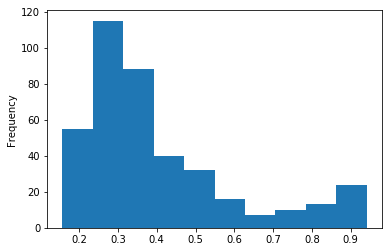

In [20]:
worker_res.prop_random.plot.hist()

In [24]:
indices_to_exclude

,round,batch,worker,mturk_id,disagree,neutral,agree,prop_random
13,1,1,5,A1P2RQ166VS5BT,0.244265,0.489481,0.266254,0.685695
19,1,2,3,A2PU5BM2YXFQQS,0.235364,0.309435,0.455201,0.825659
28,1,3,4,A1VR1XQEQQXYUE,0.153444,0.345825,0.500731,0.620384
35,1,4,3,A1K3SIFF770RB5,0.346948,0.361438,0.291614,0.889525
40,1,5,0,A29AKJXQ248KNK,0.260259,0.530716,0.209025,0.519023
...,...,...,...,...,...,...,...,...
379,5,7,3,AONRPFWPSEWX6,0.312181,0.191209,0.496610,0.941212
383,5,7,7,A2XW91EHCZ3T3V,0.236069,0.271547,0.492384,0.744748
385,5,8,1,A11M5KWP2835VO,0.366913,0.310235,0.322852,0.904175
386,5,8,2,A2YGOORS5N9RW8,0.151257,0.648289,0.200454,0.526170


In [29]:
full_ratings = pd.read_pickle('../MTurk/MTurk_results/full_ratings_per_round.pkl')

In [114]:
sources,types,texts,stances,MACEs = [],[],[],[],[]
for round_no in range(1,6):
    for batch_no in range(0,10):
        ratings = full_ratings[round_no][batch_no]
        # drop labels from low competence workers
        ratings = ratings.drop([c for c in ratings.columns[3:] 
                               if ratings[c]['MACE competence'] < 0.6], axis=1)
        for s_id in ratings.index[5:-1]:
            row = ratings.loc[s_id]
            for col in row.index[3:]:
                rating = row[col]
                sources.append('round{}_batch{}_sentid{}'.format(round_no,
                                                                batch_no,
                                                                s_id))
                types.append('mturk_flat')
                texts.append(row['sentence'])
                stances.append(rating)
                MACEs.append(row['MACE_pred'])

In [115]:
flat_mturk_df = pd.DataFrame.from_dict({
    'source':sources,'type':types,'text':texts,'stance':stances,'MACE_pred':MACEs
})

In [143]:
flat_mturk_df.to_pickle('flat_mturk_df.pkl')

In [ ]:
# need to divide portion into train, dev+test, stance of dev+test will be collapsed over 
# same source

In [60]:
#flat_mturk_df = labeled_data[labeled_data.type=='mturk_flat']

In [117]:
flat_mturk_df.head()

,source,type,text,stance,MACE_pred
0,round1_batch0_sentidt0,mturk_flat,"Warmer-than-normal sea surface temperatures are a key player in the development of hurricanes such as Katrina and superstorm Sandy, which hit the U.S. east coast in 2011.",neutral,agrees
1,round1_batch0_sentidt0,mturk_flat,"Warmer-than-normal sea surface temperatures are a key player in the development of hurricanes such as Katrina and superstorm Sandy, which hit the U.S. east coast in 2011.",neutral,agrees
2,round1_batch0_sentidt0,mturk_flat,"Warmer-than-normal sea surface temperatures are a key player in the development of hurricanes such as Katrina and superstorm Sandy, which hit the U.S. east coast in 2011.",neutral,agrees
3,round1_batch0_sentidt0,mturk_flat,"Warmer-than-normal sea surface temperatures are a key player in the development of hurricanes such as Katrina and superstorm Sandy, which hit the U.S. east coast in 2011.",agrees,agrees
4,round1_batch0_sentidt0,mturk_flat,"Warmer-than-normal sea surface temperatures are a key player in the development of hurricanes such as Katrina and superstorm Sandy, which hit the U.S. east coast in 2011.",agrees,agrees


In [118]:
flat_mturk_source_groups = flat_mturk_df.groupby('source')

In [119]:
flat_mturk_source_groups.get_group('round1_batch0_sentidt10')

,source,type,text,stance,MACE_pred
14,round1_batch0_sentidt10,mturk_flat,The actual rise in sea levels measured only 1.2 millimeters instead of the previously accepted 1.6 to 1.9 millimeters.,neutral,neutral
15,round1_batch0_sentidt10,mturk_flat,The actual rise in sea levels measured only 1.2 millimeters instead of the previously accepted 1.6 to 1.9 millimeters.,neutral,neutral
16,round1_batch0_sentidt10,mturk_flat,The actual rise in sea levels measured only 1.2 millimeters instead of the previously accepted 1.6 to 1.9 millimeters.,neutral,neutral
17,round1_batch0_sentidt10,mturk_flat,The actual rise in sea levels measured only 1.2 millimeters instead of the previously accepted 1.6 to 1.9 millimeters.,neutral,neutral
18,round1_batch0_sentidt10,mturk_flat,The actual rise in sea levels measured only 1.2 millimeters instead of the previously accepted 1.6 to 1.9 millimeters.,neutral,neutral
19,round1_batch0_sentidt10,mturk_flat,The actual rise in sea levels measured only 1.2 millimeters instead of the previously accepted 1.6 to 1.9 millimeters.,neutral,neutral
20,round1_batch0_sentidt10,mturk_flat,The actual rise in sea levels measured only 1.2 millimeters instead of the previously accepted 1.6 to 1.9 millimeters.,neutral,neutral


In [120]:
seed1 = 3535999445
train_sources, dev_test_sources = train_test_split(flat_mturk_source_groups.first().index,
                 test_size=0.3, random_state=seed1)

In [121]:
len(train_sources),len(dev_test_sources)

(1435, 615)

In [122]:
train_sources[:5]

Index(['round3_batch4_sentidt11', 'round1_batch8_sentidt27',
       'round5_batch8_sentidt25', 'round2_batch1_sentidt34',
       'round2_batch7_sentidt20'],
      dtype='object', name='source')

In [123]:
dev_sources,test_sources = train_test_split(dev_test_sources,test_size=0.6,random_state=seed1)

In [124]:
len(dev_sources),len(test_sources)

(246, 369)

In [125]:
train_df = flat_mturk_df[flat_mturk_df.source.isin(train_sources)]
dev_df = flat_mturk_df[flat_mturk_df.source.isin(dev_sources)]
test_df = flat_mturk_df[flat_mturk_df.source.isin(test_sources)]

In [126]:
train_X = train_df.text.values
train_Y = train_df.stance.values
list(zip(train_X[:3],train_Y[:3]))

[('Warmer-than-normal sea surface temperatures are a key player in the development of hurricanes such as Katrina and superstorm Sandy, which hit the U.S. east coast in 2011.',
  'neutral'),
 ('Warmer-than-normal sea surface temperatures are a key player in the development of hurricanes such as Katrina and superstorm Sandy, which hit the U.S. east coast in 2011.',
  'neutral'),
 ('Warmer-than-normal sea surface temperatures are a key player in the development of hurricanes such as Katrina and superstorm Sandy, which hit the U.S. east coast in 2011.',
  'neutral')]

In [128]:
dev_source_groups = dev_df.groupby('source')
test_source_groups = test_df.groupby('source')

In [132]:
from statistics import *

mode(dev_source_groups.get_group('round1_batch0_sentidt27').stance.values)

'disagrees'

In [133]:
dev_X,dev_Y = [],[]
for source in dev_source_groups.first().index:
    group = dev_source_groups.get_group(source)
    dev_X.append(group.text.values[0])
    try:
        dev_Y.append(mode(group.stance.values))
    except StatisticsError:
        dev_Y.append(group.MACE_pred.values[0])

In [136]:
test_X,test_Y = [],[]
for source in test_source_groups.first().index:
    group = test_source_groups.get_group(source)
    test_X.append(group.text.values[0])
    try:
        test_Y.append(mode(group.stance.values))
    except StatisticsError:
        test_Y.append(group.MACE_pred.values[0])

In [142]:
from collections import Counter
Counter(train_Y)

Counter({'neutral': 2861, 'agrees': 2332, 'disagrees': 1242})

In [55]:
labeled_data = labeled_data.append(flat_mturk_df,ignore_index=True)

In [56]:
labeled_data.shape

(687730, 4)

In [57]:
labeled_data.type.value_counts()

twint_tweet              520886
dallas_news_predicted    114686
dallas_news              40309 
mturk_flat               9245  
mturk                    2040  
semeval_train_tweets     395   
semeval_tweets           169   
Name: type, dtype: int64

In [58]:
os.getcwd()

'/Users/yiweiluo/scientific-debates/cc_stance/data_creation'

In [59]:
labeled_data.to_pickle('labeled_data_df_2.pkl')

# Dallas ELMO predicted labeled news

In [59]:
import json
lines = []
with open('data/all-predicted-sentences.jsonlist') as f:
    for line in f:
        lines.append(json.loads(line))

In [61]:
len(lines)

114686

In [60]:
lines[:3]

[{'article_id': 'climate_change1.0-6365',
  'sent_index': 0,
  'tokens': ['No',
   'Accord',
   ',',
   'and',
   'Little',
   'Optimism',
   ',',
   'at',
   'Bonn',
   'Talks',
   'on',
   'Global',
   'Warming'],
  'primary_tone': 'Pro'},
 {'article_id': 'climate_change1.0-6365',
  'sent_index': 1,
  'tokens': ['Delegates',
   'from',
   '143',
   'countries',
   'ended',
   'their',
   'preliminary',
   'talks',
   'on',
   'global',
   'warming',
   'here',
   'today',
   'with',
   'no',
   'agreement',
   'on',
   'key',
   'issues',
   'and',
   'growing',
   'concern',
   'about',
   'the',
   'prospect',
   'for',
   'success',
   'at',
   'the',
   'concluding',
   'meeting',
   ',',
   'to',
   'be',
   'held',
   'in',
   'Kyoto',
   ',',
   'Japan',
   ',',
   'in',
   'early',
   'December',
   '.'],
  'primary_tone': 'Pro'},
 {'article_id': 'climate_change1.0-6365',
  'sent_index': 2,
  'tokens': ['The',
   'United',
   'States',
   "'",
   'long-awaited',
   'proposal'

In [62]:
Counter([line['primary_tone'] for line in lines])

Counter({'Pro': 113777, 'Anti': 909})

In [64]:
labeled_data = {'source':[],'type':[],'text':[],'stance':[]}
labeled_data['source'] = [l['article_id'] + ' [SEP] ' + str(l['sent_index']) 
                          for l in lines]
labeled_data['type'] = ['dallas_news_predicted']*len(lines)
labeled_data['text'] = [' '.join(l['tokens'])[:-2]+'.' for l in lines]
labeled_data['stance'] = [tone2label[l['primary_tone'].lower()] for l in lines]
labeled_data_df = pd.DataFrame(labeled_data)
labeled_data_df.head(10)

,source,type,text,stance
0,climate_change1.0-6365 [SEP] 0,dallas_news_predicted,"No Accord , and Little Optimism , at Bonn Talks on Global Warmi.",agree
1,climate_change1.0-6365 [SEP] 1,dallas_news_predicted,"Delegates from 143 countries ended their preliminary talks on global warming here today with no agreement on key issues and growing concern about the prospect for success at the concluding meeting , to be held in Kyoto , Japan , in early December.",agree
2,climate_change1.0-6365 [SEP] 2,dallas_news_predicted,The United States ' long-awaited proposal for cutting emissions of heat-trapping greenhouse gases has been scornfully attacked as too weak by delegates and environmentalists from around the world.,agree
3,climate_change1.0-6365 [SEP] 3,dallas_news_predicted,And there is no sign that American negotiators are about to yield.,agree
4,climate_change1.0-6365 [SEP] 4,dallas_news_predicted,"Still , the Americans themselves said there was more than a little cause for hope , and they have been lobbying their counterparts here , urging them to take a closer look at the American proposal.",agree
5,climate_change1.0-6365 [SEP] 5,dallas_news_predicted,"Meanwhile , several small-scale but higher-level meetings will be held between now and Dec. 1 , when the Kyoto conference begins.",agree
6,climate_change1.0-6365 [SEP] 6,dallas_news_predicted,"The goal of the conference is to revise the climate treaty negotiated in Rio in 1992 , which set voluntary limits on emissions.",agree
7,climate_change1.0-6365 [SEP] 7,dallas_news_predicted,"`` There are enough ideas out there to have an agreement , '' a senior State Department official said here , speaking on condition of anonymity.",agree
8,climate_change1.0-6365 [SEP] 8,dallas_news_predicted,`` We just do n't see all the kinds of coalescence that you need yet '' for that to happen.,agree
9,climate_change1.0-6365 [SEP] 9,dallas_news_predicted,"On the surface , the American proposal looks like the weakest on the table.",agree


In [70]:
labeled_data_df.shape

(114686, 4)

In [71]:
labeled_data = labeled_data.append(labeled_data_df, ignore_index = True)
labeled_data.to_csv('./tweet-stance-prediction/data/labeled_data_df')

# Dallas new labeled news

In [32]:
import json
lines = []
with open('data/all-annotated-sentences.jsonlist') as f:
    for line in f:
        lines.append(json.loads(line))

In [33]:
len(lines)

40790

In [34]:
lines[:5]

[{'article_id': 'climate_change1.0-12174',
  'sent_index': 0,
  'tokens': ['It',
   "'s",
   'about',
   'seeing',
   'the',
   'forest',
   'and',
   'the',
   'trees',
   'in',
   'Calif.',
   ';',
   'Scientists',
   'study',
   'global',
   'warming',
   "'s",
   'effect',
   'on',
   'redwoods',
   'and',
   'sequoias'],
  'primary_tone': 'Pro'},
 {'article_id': 'climate_change1.0-12174',
  'sent_index': 1,
  'tokens': ['Two',
   'of',
   'his',
   'colleagues',
   'dangled',
   'on',
   'ropes',
   '100',
   'feet',
   'above',
   'from',
   'the',
   'gnarled',
   'branches',
   'of',
   'a',
   'giant',
   'sequoia',
   'tree',
   '.'],
  'primary_tone': 'Pro'},
 {'article_id': 'climate_change1.0-12174',
  'sent_index': 2,
  'tokens': ['Steve',
   'Sillett',
   'could',
   'hardly',
   'contain',
   'his',
   'excitement',
   '.'],
  'primary_tone': 'Pro'},
 {'article_id': 'climate_change1.0-12174',
  'sent_index': 3,
  'tokens': ['``', 'This', 'site', 'is', 'just', 'juicy', '.

In [35]:
Counter([line['primary_tone'] for line in lines])

Counter({'Pro': 30917, 'Neutral': 3685, 'Anti': 6188})

In [40]:
tone2label = {'pro':'agree','anti':'disagree','neutral':'neutral'}

In [37]:
neutral_lines = [l for l in lines if l['primary_tone'] == 'Neutral']
len(neutral_lines)

3685

In [41]:
# Add all the neutrals to labeled_data_df
labeled_data = {'source':[],'type':[],'text':[],'stance':[]}
labeled_data['source'] = [l['article_id'] + ' [SEP] ' + str(l['sent_index']) 
                          for l in neutral_lines]
labeled_data['type'] = ['dallas_news']*len(neutral_lines)
labeled_data['text'] = [' '.join(l['tokens']) for l in neutral_lines]
labeled_data['stance'] = [tone2label[l['primary_tone'].lower()] for l in neutral_lines]
labeled_data_df = pd.DataFrame(labeled_data)
labeled_data_df.head(10)

,source,type,text,stance
0,climate_change1.0-9251 [SEP] 0,dallas_news,From Nuclear Freeze to Global Warming - and Back,neutral
1,climate_change1.0-9251 [SEP] 1,dallas_news,"In June 1982 , up to a million demonstrators gathered in Central Park calling for a nuclear freeze .",neutral
2,climate_change1.0-9251 [SEP] 2,dallas_news,"They were protesting the Reagan-era nuclear arms buildup and other developments they saw , not unreasonably , as a threat to civilization and to life on Earth , including talk by some Reagan aides about fighting and winning a nuclear war .",neutral
3,climate_change1.0-9251 [SEP] 3,dallas_news,"Last Sunday - a generation later - hundreds of thousands of demonstrators took part in the People 's Climate March in Manhattan to protest international inaction on global warming , which they see , not unreasonably , as a threat to civilization and to life on Earth.The front page of The New York Times on Monday brought the two events together , in an unintended though instructive way .",neutral
4,climate_change1.0-9251 [SEP] 4,dallas_news,The photographs were of the climate marchers .,neutral
5,climate_change1.0-9251 [SEP] 5,dallas_news,But the lead story was about the current aggressive efforts to rebuild the nation 's nuclear arsenal .,neutral
6,climate_change1.0-9251 [SEP] 6,dallas_news,"The fact that , 32 years after the Central Park gathering , progress on significant arms reductions is going into reverse is something the climate marchers should note .",neutral
7,climate_change1.0-9251 [SEP] 7,dallas_news,"Because , intentionally or not , the climate change movement mirrors the nuclear freeze in many ways .",neutral
8,climate_change1.0-9251 [SEP] 8,dallas_news,Both are rooted in the idea of a global planetary emergency .,neutral
9,climate_change1.0-9251 [SEP] 9,dallas_news,Both grew along with scientific evidence that challenges the status quo in politics and industry .,neutral


In [42]:
labeled_data_df.shape

(3685, 4)

In [47]:
labeled_data.shape

(39228, 5)

In [58]:
39228+3685

42913

In [53]:
labeled_data = labeled_data.append(labeled_data_df, ignore_index = True)
labeled_data.to_csv('./tweet-stance-prediction/data/labeled_data_df')

# Dallas labeled news

In [15]:
import json
lines = []
with open('data/all.pro-anti.sentences.jsonlist') as f:
    for line in f:
        lines.append(json.loads(line))

In [16]:
len(lines)

37105

In [22]:
lines[:5]

[{'article_id': 'climate_change1.0-12174',
  'sent_index': 0,
  'text': "It's about seeing the forest and the trees in Calif.; Scientists study global warming's effect on redwoods and sequoias",
  'tokens': ['It',
   "'s",
   'about',
   'seeing',
   'the',
   'forest',
   'and',
   'the',
   'trees',
   'in',
   'Calif.',
   ';',
   'Scientists',
   'study',
   'global',
   'warming',
   "'s",
   'effect',
   'on',
   'redwoods',
   'and',
   'sequoias'],
  'primary_tone': 'Pro'},
 {'article_id': 'climate_change1.0-12174',
  'sent_index': 1,
  'text': 'Two of his colleagues dangled on ropes 100 feet above from the gnarled branches of a giant sequoia tree.',
  'tokens': ['Two',
   'of',
   'his',
   'colleagues',
   'dangled',
   'on',
   'ropes',
   '100',
   'feet',
   'above',
   'from',
   'the',
   'gnarled',
   'branches',
   'of',
   'a',
   'giant',
   'sequoia',
   'tree',
   '.'],
  'primary_tone': 'Pro'},
 {'article_id': 'climate_change1.0-12174',
  'sent_index': 2,
  'text'

In [38]:
Counter([l['primary_tone'].lower() for l in lines])

Counter({'pro': 30917, 'anti': 6188})

In [39]:
tone2label = {'pro':'agree','anti':'disagree'}

In [58]:

labeled_data['source'] = [l['article_id'] + ' [SEP] ' + str(l['sent_index']) for l in lines]
labeled_data['type'] = ['dallas_news']*len(lines)
labeled_data['text'] = [l['text'] for l in lines]
labeled_data['stance'] = [tone2label[l['primary_tone'].lower()] for l in lines]
labeled_data_df = pd.DataFrame(labeled_data)
labeled_data_df.head(10)

,source,type,text,stance
0,climate_change1.0-12174 [SEP] 0,dallas_news,It's about seeing the forest and the trees in ...,agree
1,climate_change1.0-12174 [SEP] 1,dallas_news,Two of his colleagues dangled on ropes 100 fee...,agree
2,climate_change1.0-12174 [SEP] 2,dallas_news,Steve Sillett could hardly contain his excitem...,agree
3,climate_change1.0-12174 [SEP] 3,dallas_news,"""This site is just juicy.",agree
4,climate_change1.0-12174 [SEP] 4,dallas_news,"It's loaded,"" said Sillett, gazing up at the a...",agree
5,climate_change1.0-12174 [SEP] 5,dallas_news,"""There are amazing lichens up there.",agree
6,climate_change1.0-12174 [SEP] 6,dallas_news,There are aphids being hunted by ladybugs.,agree
7,climate_change1.0-12174 [SEP] 7,dallas_news,I found a sizable dogwood tree growing from a ...,agree
8,climate_change1.0-12174 [SEP] 8,dallas_news,"The foggy, lost worlds atop the world's bigges...",agree
9,climate_change1.0-12174 [SEP] 9,dallas_news,Concerned that rising temperatures across Cali...,agree


# Dallas unlabeled news

In [9]:
os.getcwd()

'/Users/yiweiluo/scientific-debates/cc_stance'

In [25]:
all_sents = []
with open('data/all.sentences.jsonlist') as f:
    for line in f:
        all_sents.append(json.loads(line))

In [11]:
len(all_sents)

126100

In [21]:
len([line['primary_tone'] for line in all_sents if 'primary_tone' in line])

0

In [26]:
all_sents[:10]

[{'article_id': 'climate_change1.0-6365',
  'sent_index': 0,
  'text': 'No Accord, and Little Optimism, at Bonn Talks on Global Warming',
  'tokens': ['No',
   'Accord',
   ',',
   'and',
   'Little',
   'Optimism',
   ',',
   'at',
   'Bonn',
   'Talks',
   'on',
   'Global',
   'Warming']},
 {'article_id': 'climate_change1.0-6365',
  'sent_index': 1,
  'text': 'Delegates from 143 countries ended their preliminary talks on global warming here today with no agreement on key issues and growing concern about the prospect for success at the concluding meeting, to be held in Kyoto, Japan, in early December.',
  'tokens': ['Delegates',
   'from',
   '143',
   'countries',
   'ended',
   'their',
   'preliminary',
   'talks',
   'on',
   'global',
   'warming',
   'here',
   'today',
   'with',
   'no',
   'agreement',
   'on',
   'key',
   'issues',
   'and',
   'growing',
   'concern',
   'about',
   'the',
   'prospect',
   'for',
   'success',
   'at',
   'the',
   'concluding',
   'meet

In [20]:
'climate_change1.0-6365 [SEP] 0' in labeled_data_df['source']

False

In [84]:
#all_sents[1]

In [178]:
unlabeled_data['source'] = [l['article_id'] + ' [SEP] ' + str(l['sent_index']) 
                               for l in all_sents]
unlabeled_data['type'] = ['dallas_news']*len(all_sents)
unlabeled_data['text'] = [l['text'] for l in all_sents]
unlabeled_data_df = pd.DataFrame(unlabeled_data)
unlabeled_data_df.head(10)

,source,type,text
0,climate_change1.0-6365 [SEP] 0,dallas_news,"No Accord, and Little Optimism, at Bonn Talks ..."
1,climate_change1.0-6365 [SEP] 1,dallas_news,Delegates from 143 countries ended their preli...
2,climate_change1.0-6365 [SEP] 2,dallas_news,The United States' long-awaited proposal for c...
3,climate_change1.0-6365 [SEP] 3,dallas_news,And there is no sign that American negotiators...
4,climate_change1.0-6365 [SEP] 4,dallas_news,"Still, the Americans themselves said there was..."
5,climate_change1.0-6365 [SEP] 5,dallas_news,"Meanwhile, several small-scale but higher-leve..."
6,climate_change1.0-6365 [SEP] 6,dallas_news,The goal of the conference is to revise the cl...
7,climate_change1.0-6365 [SEP] 7,dallas_news,"""There are enough ideas out there to have an a..."
8,climate_change1.0-6365 [SEP] 8,dallas_news,"""We just don't see all the kinds of coalescenc..."
9,climate_change1.0-6365 [SEP] 9,dallas_news,"On the surface, the American proposal looks li..."


# SemEval tweets

In [4]:
targets = []
with open(os.getcwd()+'/data/semeval2016-task6-testdata-gold/SemEval2016-Task6-subtaskB-testdata\
-gold.txt') as f:
    semeval_b = f.readlines()
    for line in semeval_b[1:]:
        id_,target,tweet,stance = line.strip().split('\t')
        targets.append(target)

In [5]:
from collections import Counter
Counter(targets)

Counter({'Donald Trump': 707})

In [6]:
semeval_tweets = []
with open(os.getcwd()+'/data/semeval2016-task6-testdata-gold/SemEval2016-Task6-subtaskA-testdata\
-gold.txt') as f:
    semeval_a = f.readlines()
    for line in semeval_a[1:]:
        id_,target,tweet,stance = line.strip().split('\t')
        if target == 'Climate Change is a Real Concern':
            semeval_tweets.append(line.strip().split('\t'))

In [7]:
len(semeval_tweets)

169

In [8]:
from collections import Counter
Counter([x[-1] for x in semeval_tweets])

Counter({'NONE': 35, 'FAVOR': 123, 'AGAINST': 11})

In [9]:
tweetstance2label = {'NONE':'neutral','FAVOR':'agree','AGAINST':'disagree'}

In [11]:
labeled_data['source'].extend([l[0] for l in semeval_tweets])
labeled_data['type'].extend(['semeval_tweets']*len(semeval_tweets))
labeled_data['text'].extend([l[2] for l in semeval_tweets])
labeled_data['stance'].extend([tweetstance2label[l[3]] for l in semeval_tweets])
labeled_data_df = pd.DataFrame(labeled_data)
labeled_data_df.head(10)

,source,type,text,stance
0,10221,semeval_tweets,Closed door session begins. More after they de...,neutral
1,10222,semeval_tweets,What is the #energiewende agenda? Why are they...,agree
2,10223,semeval_tweets,@climasphere Stocker: Fish catch potential cou...,agree
3,10224,semeval_tweets,"...a longer memory, and a sterner sense of jus...",neutral
4,10225,semeval_tweets,"Boni ""Future Sea level rise will not be unifor...",agree
5,10226,semeval_tweets,@climasphere Bony: Extreme weather events (hea...,agree
6,10227,semeval_tweets,Camille Parmesan: 2/3 of species have changed ...,agree
7,10228,semeval_tweets,5 meta-analyses show 1/2 of species have chang...,agree
8,10229,semeval_tweets,It literarly just took me 10 minutes to get in...,neutral
9,10230,semeval_tweets,Grubb: state of energy: shift US & EU from net...,agree


In [12]:
semeval_tweets

[['10221',
  'Climate Change is a Real Concern',
  'Closed door session begins. More after they decide on the entities.  #GCF #SemST',
  'NONE'],
 ['10222',
  'Climate Change is a Real Concern',
  'What is the #energiewende agenda? Why are they not in the "de-carbonizer" camp?.  How long will you tolerate the lies?  #SemST',
  'FAVOR'],
 ['10223',
  'Climate Change is a Real Concern',
  '@climasphere Stocker: Fish catch potential could drop by as much as 50% in some areas due to #oceanacidification. #CFCC15 #SemST',
  'FAVOR'],
 ['10224',
  'Climate Change is a Real Concern',
  '...a longer memory, and a sterner sense of justice than we do. -W.Berry #SemST',
  'NONE'],
 ['10225',
  'Climate Change is a Real Concern',
  'Boni "Future Sea level rise will not be uniform & different for coasts" #CCFC15 #Journey2015 #SemST',
  'FAVOR'],
 ['10226',
  'Climate Change is a Real Concern',
  '@climasphere Bony: Extreme weather events (heat waves, drought, flooding, windstorms) made more frequent

In [43]:
labeled_data_df.tail(10)

,source,type,text,stance
37264,10380,semeval_tweets,@4EvaMartino Everyone should learn this recip...,agree
37265,10381,semeval_tweets,Rec high temp for this date in Charlotte is 10...,agree
37266,10382,semeval_tweets,"Lot's of time, class over! @nationaljournal #S...",neutral
37267,10383,semeval_tweets,@TheLibertyEagle Oh for the love of Pete! I th...,neutral
37268,10384,semeval_tweets,If complaining about irrelevant problems were ...,neutral
37269,10385,semeval_tweets,"@LiberalAus - ""All"" you folks #owe me an #offi...",neutral
37270,10386,semeval_tweets,"Maybe we should start ""labelling every #produc...",agree
37271,10387,semeval_tweets,If we touch #Antarctica for one more #reason o...,agree
37272,10388,semeval_tweets,Wind power helped stabilize Texas' power grid ...,agree
37273,10389,semeval_tweets,"It's so cold and windy here in Sydney, I just ...",agree


In [13]:
stance_test = pd.read_csv(open(os.getcwd()+'/data/StanceDataset/test.csv','rU'),
                          encoding='utf-8', engine='c')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 'U' mode is deprecated
  """Entry point for launching an IPython kernel.


In [14]:
stance_test = stance_test[stance_test['Target'] == 'Climate Change is a Real Concern']

In [15]:
stance_test.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
220,Closed door session begins. More after they de...,Climate Change is a Real Concern,NONE,3. The tweet is not explicitly expressing opi...,other
221,What is the #energiewende agenda? Why are they...,Climate Change is a Real Concern,FAVOR,1. The tweet explicitly expresses opinion abo...,neg
222,@climasphere Stocker: Fish catch potential cou...,Climate Change is a Real Concern,FAVOR,1. The tweet explicitly expresses opinion abo...,neg
223,"...a longer memory, and a sterner sense of jus...",Climate Change is a Real Concern,NONE,2. The tweet does NOT expresses opinion about ...,other
224,"Boni ""Future Sea level rise will not be unifor...",Climate Change is a Real Concern,FAVOR,1. The tweet explicitly expresses opinion abo...,other


In [16]:
labeled_data['source'].extend(list(stance_test.index))
labeled_data['type'].extend(['semeval_test_tweets']*len(stance_test))
labeled_data['text'].extend([stance_test.loc[l]['Tweet'] for l in stance_test.index])
labeled_data['stance'].extend([tweetstance2label[stance_test.loc[l]['Stance']] 
                               for l in stance_test.index])
labeled_data_df = pd.DataFrame(labeled_data)
labeled_data_df.head(10)

,source,type,text,stance
0,10221,semeval_tweets,Closed door session begins. More after they de...,neutral
1,10222,semeval_tweets,What is the #energiewende agenda? Why are they...,agree
2,10223,semeval_tweets,@climasphere Stocker: Fish catch potential cou...,agree
3,10224,semeval_tweets,"...a longer memory, and a sterner sense of jus...",neutral
4,10225,semeval_tweets,"Boni ""Future Sea level rise will not be unifor...",agree
5,10226,semeval_tweets,@climasphere Bony: Extreme weather events (hea...,agree
6,10227,semeval_tweets,Camille Parmesan: 2/3 of species have changed ...,agree
7,10228,semeval_tweets,5 meta-analyses show 1/2 of species have chang...,agree
8,10229,semeval_tweets,It literarly just took me 10 minutes to get in...,neutral
9,10230,semeval_tweets,Grubb: state of energy: shift US & EU from net...,agree


In [61]:
labeled_data_df.tail(10)

,source,type,text,stance
37433,379,semeval_test_tweets,@4EvaMartino Everyone should learn this recip...,agree
37434,380,semeval_test_tweets,Rec high temp for this date in Charlotte is 10...,agree
37435,381,semeval_test_tweets,"Lot's of time, class over! @nationaljournal #S...",neutral
37436,382,semeval_test_tweets,@TheLibertyEagle Oh for the love of Pete! I th...,neutral
37437,383,semeval_test_tweets,If complaining about irrelevant problems were ...,neutral
37438,384,semeval_test_tweets,"@LiberalAus - ""All"" you folks #owe me an #offi...",neutral
37439,385,semeval_test_tweets,"Maybe we should start ""labelling every #produc...",agree
37440,386,semeval_test_tweets,If we touch #Antarctica for one more #reason o...,agree
37441,387,semeval_test_tweets,Wind power helped stabilize Texas' power grid ...,agree
37442,388,semeval_test_tweets,"It's so cold and windy here in Sydney, I just ...",agree


In [18]:
stance_train = pd.read_csv(open(os.getcwd()+'/data/StanceDataset/train.csv','rU'),
                          encoding='utf-8', engine='c')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 'U' mode is deprecated
  """Entry point for launching an IPython kernel.


In [19]:
stance_train = stance_train[stance_train['Target'] == 'Climate Change is a Real Concern']

In [20]:
stance_train.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
613,"We cant deny it, its really happening. #SemST",Climate Change is a Real Concern,FAVOR,1. The tweet explicitly expresses opinion abo...,other
614,RT @cderworiz: Timelines are short. Strategy m...,Climate Change is a Real Concern,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
615,SO EXCITING! Meaningful climate change action ...,Climate Change is a Real Concern,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
616,"Delivering good jobs for Albertans, maintainin...",Climate Change is a Real Concern,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
617,@davidswann says he wants carbon fund to be sp...,Climate Change is a Real Concern,FAVOR,3. The tweet is not explicitly expressing opi...,other


In [24]:
labeled_data['source'].extend(list(stance_train.index))
labeled_data['type'].extend(['semeval_train_tweets']*len(stance_train))
labeled_data['text'].extend([stance_train.loc[l]['Tweet'] for l in stance_train.index])
labeled_data['stance'].extend([tweetstance2label[stance_train.loc[l]['Stance']] 
                               for l in stance_train.index])
labeled_data_df = pd.DataFrame(labeled_data)
labeled_data_df.head(10)

,source,type,text,stance
0,10221,semeval_tweets,Closed door session begins. More after they decide on the entities. #GCF #SemST,neutral
1,10222,semeval_tweets,"What is the #energiewende agenda? Why are they not in the ""de-carbonizer"" camp?. How long will you tolerate the lies? #SemST",agree
2,10223,semeval_tweets,@climasphere Stocker: Fish catch potential could drop by as much as 50% in some areas due to #oceanacidification. #CFCC15 #SemST,agree
3,10224,semeval_tweets,"...a longer memory, and a sterner sense of justice than we do. -W.Berry #SemST",neutral
4,10225,semeval_tweets,"Boni ""Future Sea level rise will not be uniform & different for coasts"" #CCFC15 #Journey2015 #SemST",agree
5,10226,semeval_tweets,"@climasphere Bony: Extreme weather events (heat waves, drought, flooding, windstorms) made more frequent/intense by #CFCC15 #SemST",agree
6,10227,semeval_tweets,Camille Parmesan: 2/3 of species have changed #habitat because of #H12 #CFCC15 #SemST,agree
7,10228,semeval_tweets,"5 meta-analyses show 1/2 of species have changed where they live, 2/3 have changed when they live. Camille Parmesan #CFCC15 #SemST",agree
8,10229,semeval_tweets,It literarly just took me 10 minutes to get in a bus because an old lady just had to go in front of everyone... #SemST,neutral
9,10230,semeval_tweets,"Grubb: state of energy: shift US & EU from net-producer to net-importer of emissions"" #CCFC15 #journey2015 #SemST",agree


In [26]:
labeled_data_df[labeled_data_df.stance=='disagree']

,source,type,text,stance
99,10320,semeval_tweets,ONE Volcano emits more pollution than man has in our HISTORY! #SemST,disagree
109,10330,semeval_tweets,@UN ice cracking in the summer?? SO ALARMING. #climatechangehoax #SemST,disagree
120,10341,semeval_tweets,"#ClimateChangeDefinitions ""settled science"" = flawed computer models with jiggered data to force a predefined conclusion. #SemST",disagree
127,10348,semeval_tweets,@Myrmecos Still a larval theory. Still poorly modelled. Still unquantified. Still multi-factor. Still flummoxed by albedo. #SemST,disagree
136,10357,semeval_tweets,Climate deniers is a term used to silence those pointing out the hypocrisy in the fanatical zeal on #climatetruth #SemST,disagree
145,10366,semeval_tweets,"@wattsupwiththat yes ironic that the alarmists are the actual ""deniers #SemST",disagree
146,10367,semeval_tweets,@JustinTrudeau Hey Justin I will give you 50 cents if you stop talking about climate 'Change' #Ottawa #davidsuzuki #cbc #SemST,disagree
147,10368,semeval_tweets,If @EPA & @POTUS don't have to follow SCOTUS why should anyone else have to #ClimateFraud #SpecialReport #WakeUpAmerica #SemST,disagree
149,10370,semeval_tweets,"Govt announcement on zero carbon homes ""short-sighted, unnecessary, retrograde and damaging"" says @UKGBC #energyefficiency #SemST",disagree
151,10372,semeval_tweets,"We are not ""killing the Earth"". The Earth has been through worse and will be fine after all humans suffocate, drown or starve #SemST",disagree


# Dallas and Yiwei manually annotated news--not yet added

In [28]:
import json
dallas_labels = []
with open('subsample_annotated_dbc.jsonlist') as f:
    for line in f:
        dallas_labels.append(json.loads(line))

In [29]:
len(dallas_labels)

300

In [34]:
dallas_labels[10:20]

[{'comp_clause': "that measures such as conservation wo n't cost much and will buy insurance against global warming",
  'full': "Some argue that measures such as conservation won't cost much and will buy insurance against global warming.",
  'key': 106901,
  'label': 0},
 {'comp_clause': 'I became somewhat inspired',
  'full': '"I became somewhat inspired," he said.',
  'key': 143590,
  'label': 3},
 {'comp_clause': 'if he ’s joking',
  'full': '“I would argue, as would many other beeologists,” he says, “that most bees are arguably cuter than most kids.” It’s hard to tell if he’s joking.',
  'key': 61472,
  'label': 3},
 {'comp_clause': 'the Earth habitable',
  'full': 'Gases such as carbon dioxide trap the energy that pours down on the Earth from the sun, making the Earth habitable.',
  'key': 276801,
  'label': 2},
 {'comp_clause': 'Rescue workers tried to \xa0 expand the sweater idea to pelicans \xa0 during the Gulf spill in 2010',
  'full': 'Rescue workers tried to\xa0expand the sw

In [31]:
yiwei_labels = pd.read_csv('subsample_annotated_yiwei.csv',header=None)

In [32]:
yiwei_labels.head()

,0,1,2,3
0,19565,"Reading ""an early draft"" of a federal government report has helped David Ignatius see that the global warming debate is just like the tobacco wars of the past four decades [""Naysay Now, Pay Later,"" op-ed, Aug. 18].",that the global warming debate is just like the tobacco wars of the past four decades,1
1,92670,"We haven’t seen that in the observations,” Myles Allen, professor of geosystem science at the University of Oxford and one of the study’s authors, told the Times of London, as reported in The Independent.","that in the observations , ” Myles Allen , professor of geosystem science at the University of Oxford and one of the study ’s authors , told the Times of London , as reported in The Independent",2
2,152040,"Describing it as a rare hybrid “superstorm,” forecasters say Sandy was created by an Arctic jet stream wrapping itself around a tropical storm.",Sandy was created by an Arctic jet stream wrapping itself around a tropical storm,2
3,191315,JEFFERSON CITY o Ameren Missouri says it must decide quickly on how to comply with proposed Environmental Protection Agency rules limiting carbon pollution.,it must decide quickly on how to comply with proposed Environmental Protection Agency rules limiting carbon pollution,2
4,250921,"There was this exposé in the Times where you first were talking to Andrew Revkin and explaining what was happening under the Bush administration, and even before that, the suppression of your work when you testified before Congress to, what, Senator Al Gore at the time.","what was happening under the Bush administration ,",3


In [75]:
anti_test_data = []
pro_test_data = []
with open(os.getcwd()+'/test_data/anti-cc/test_data.txt') as f:
    for line in f:
        anti_test_data.append(line.split('\t'))
with open(os.getcwd()+'/test_data/pro-cc/test_data.txt') as f:
    for line in f:
        pro_test_data.append(line.split('\t'))

In [76]:
len(anti_test_data)

92804

In [77]:
anti_test_data[0]

['We ’re also doing some avian and marine mammal monitoring',
 '',
 'sent_no_29 of https://www.csmonitor.com/Environment/2010/1012/Will-Google-wind-power-project-harm-wildlife-Depends-on-location.',
 '',
 '“We’re also doing some avian and marine mammal monitoring,” says Rhonda Jackson, a spokesman for Fishermen’s Energy.\n']

In [78]:
len(pro_test_data)

581383

In [81]:
Counter([len(d) for d in pro_test_data])

Counter({5: 286327,
         1: 290241,
         17: 2316,
         6: 113,
         7: 59,
         9: 34,
         29: 2,
         14: 27,
         11: 33,
         8: 12,
         15: 1,
         53: 353,
         273: 56,
         292: 1,
         111: 91,
         106: 464,
         138: 459,
         271: 165,
         103: 209,
         145: 1,
         107: 12,
         60: 5,
         75: 11,
         54: 7,
         68: 6,
         132: 2,
         94: 2,
         128: 5,
         348: 17,
         95: 1,
         57: 1,
         283: 1,
         71: 11,
         354: 13,
         360: 1,
         380: 2,
         401: 1,
         74: 1,
         129: 2,
         69: 17,
         369: 2,
         414: 1,
         70: 4,
         77: 2,
         318: 4,
         117: 14,
         91: 7,
         139: 5,
         121: 8,
         130: 3,
         358: 5,
         362: 2,
         287: 1,
         169: 7,
         186: 4,
         203: 4,
         277: 6,
         382: 5,
      

# Yiwei unlabeled news

In [98]:
all_url_df = pd.read_pickle('/Users/yiweiluo/Dropbox/research/\
QP2/code/Fox_and_friends/all_urls_meta_and_fulltext_df_2020.pkl')

In [99]:
cc_all_url_df = all_url_df[all_url_df['topic'] == 'cc'][all_url_df['bad NYT'] == False]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [100]:
cc_all_url_df.head()

,bad NYT,date,domain,fulltext,stance,title,topic,url
1600,False,None,:///,If you can't sleep as much as you need durin...,anti,None,cc,foxnews.com/lifestyle/climate-change-might-be-...
1601,False,None,:///,Paper says draft document by scientists direct...,anti,None,cc,foxnews.com/opinion/climate-policy-get-ready-f...
1602,False,None,:///,The public's concern about global warming has ...,anti,None,cc,foxnews.com/opinion/physicist-dont-fall-for-th...
1603,False,None,:///,The federal report by dozens of U.S. governmen...,anti,None,cc,foxnews.com/politics/junk-science-studies-behi...
1604,False,None,:///,File photo - A statue of the Virgin Mary is ...,anti,None,cc,foxnews.com/science/10-years-after-hurricane-k...


In [102]:
cc_all_url_df.shape

(17601, 8)

In [181]:
from nltk.tokenize import sent_tokenize
for ix,row in cc_all_url_df.iterrows():
    source = row['url']
    type_ = 'yiwei_news'
    if row['fulltext'] is not None:
        text = sent_tokenize(row['fulltext'])
        unlabeled_data['text'].extend(text)
        unlabeled_data['type'].extend([type_]*len(text))
        unlabeled_data['source'].extend([source]*len(text))

In [192]:
unlabeled_data_df = pd.DataFrame(unlabeled_data)
unlabeled_data_df.head(10)

,source,type,text
0,climate_change1.0-6365 [SEP] 0,dallas_news,"No Accord, and Little Optimism, at Bonn Talks ..."
1,climate_change1.0-6365 [SEP] 1,dallas_news,Delegates from 143 countries ended their preli...
2,climate_change1.0-6365 [SEP] 2,dallas_news,The United States' long-awaited proposal for c...
3,climate_change1.0-6365 [SEP] 3,dallas_news,And there is no sign that American negotiators...
4,climate_change1.0-6365 [SEP] 4,dallas_news,"Still, the Americans themselves said there was..."
5,climate_change1.0-6365 [SEP] 5,dallas_news,"Meanwhile, several small-scale but higher-leve..."
6,climate_change1.0-6365 [SEP] 6,dallas_news,The goal of the conference is to revise the cl...
7,climate_change1.0-6365 [SEP] 7,dallas_news,"""There are enough ideas out there to have an a..."
8,climate_change1.0-6365 [SEP] 8,dallas_news,"""We just don't see all the kinds of coalescenc..."
9,climate_change1.0-6365 [SEP] 9,dallas_news,"On the surface, the American proposal looks li..."


In [193]:
unlabeled_data_df.tail(10)

,source,type,text
1158101,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,"and ""do you have a signed ration card from you..."
1158102,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,You can stand by but there's no telling when a...
1158103,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,Comrade.
1158104,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,"Now, a really good high-speed rail system woul..."
1158105,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,Let's say something that can travel at 500 mil...
1158106,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,"Something that can go to every major city, and..."
1158107,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,"Something that doesn't need new rights of way,..."
1158108,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,Something where the rights of way are as free ...
1158109,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,But hoping for something like that is just cra...
1158110,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,https://pjmedia.com/trending/aoc-and-the-magic...


# Clean, dedup, filter labeled and unlabeled data

In [110]:
# Functions for importing & cleaning labeled items
def lower(s):
    return s.lower()

def imports(filename):
    imp = pd.read_pickle(filename)
    imp = imp.drop_duplicates()
    imp['sent_clean'] = imp['sentence'].str.replace('http\S+|www.\S+|pic.twitter.com\S+', '', case=False)
    #imp['sent_clean'] = imp['sentence'].replace('[^A-Za-z0-9 ]+','',regex=True)
    imp['sent_clean'] = imp['sent_clean'].apply(lower)
    return imp

def clean(x):
    return x.replace('http\S+|www.\S+|pic.twitter.com\S+', '')

In [194]:
unlabeled_data_df = unlabeled_data_df.dropna()
unlabeled_data_df['text'] = unlabeled_data_df['text'].apply(clean)
unlabeled_data_df.drop_duplicates(subset= 'text',inplace=True)
unlabeled_data_df = unlabeled_data_df.reset_index()

In [195]:
labeled_data_df = labeled_data_df.dropna()
labeled_data_df['text'] = labeled_data_df['text'].apply(clean)
labeled_data_df.drop_duplicates(subset= 'text',inplace=True)
labeled_data_df = labeled_data_df.reset_index()

In [196]:
labeled_data_df = labeled_data_df.drop(['index'],axis=1)

In [197]:
unlabeled_data_df.shape

(866654, 4)

In [198]:
labeled_data_df.shape

(39228, 4)

In [ ]:
# summary of what's included

In [199]:
unlabeled_data_df.tail(10)

,index,source,type,text
866644,1158101,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,"and ""do you have a signed ration card from you..."
866645,1158102,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,You can stand by but there's no telling when a...
866646,1158103,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,Comrade.
866647,1158104,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,"Now, a really good high-speed rail system woul..."
866648,1158105,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,Let's say something that can travel at 500 mil...
866649,1158106,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,"Something that can go to every major city, and..."
866650,1158107,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,"Something that doesn't need new rights of way,..."
866651,1158108,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,Something where the rights of way are as free ...
866652,1158109,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,But hoping for something like that is just cra...
866653,1158110,https://pjmedia.com/trending/aoc-and-the-magic...,yiwei_news,https://pjmedia.com/trending/aoc-and-the-magic...


In [1]:
unlabeled_data_df['type'].value_counts() 

NameError: name 'unlabeled_data_df' is not defined

In [ ]:
labeled_data_df

In [173]:
labeled_data_df.to_csv('labeled_data_df')

In [202]:
labeled_data_df['stance'].value_counts()

agree       31629
disagree     6534
neutral      1065
Name: stance, dtype: int64

In [203]:
labeled_data_df['type'].value_counts()

dallas_news             36624
mturk                    2040
semeval_train_tweets      395
semeval_tweets            169
Name: type, dtype: int64

In [3]:
labeled_data_df = pd.read_csv(os.getcwd()+'/tweet-stance-prediction/data/labeled_data_df')

In [4]:
labeled_data_df.shape

(39228, 5)

In [5]:
labeled_data_df.type.value_counts()

dallas_news             36624
mturk                   2040 
semeval_train_tweets    395  
semeval_tweets          169  
Name: type, dtype: int64

In [6]:
labeled_data_df.loc[labeled_data_df.type=='dallas_news'].stance.value_counts()

agree       30517
disagree    6107 
Name: stance, dtype: int64

In [39]:
mturk_data = labeled_data_df[labeled_data_df.type=='mturk']

In [40]:
mturk_data.shape

(2040, 5)

In [41]:
mturk_data.stance.value_counts()

neutral     862
agree       777
disagree    401
Name: stance, dtype: int64

In [158]:
dallas_sentence_scores = pd.read_csv('/Users/yiweiluo/scientific-debates/\
cc_stance/MTurk_results/sent_scores_df.tsv',delimiter='\t')
dallas_sentence_scores['max_prob_label'] = dallas_sentence_scores[['disagree',
                                                                  'neutral',
                                                                  'agree']].idxmax(axis=1)

In [161]:
labeled_data['source'].extend(['round{}_batch{}_sentid{}'.format(row['round'],
                                                              row['batch'],
                                                              row['sent_id'])
                              for ix,row in dallas_sentence_scores.iterrows()])
labeled_data['type'].extend(['mturk']*len(dallas_sentence_scores))
labeled_data['text'].extend([row['sentence'] for ix,row in 
                             dallas_sentence_scores.iterrows()])
labeled_data['stance'].extend([row['max_prob_label'] for ix,row in 
                             dallas_sentence_scores.iterrows()])
labeled_data_df = pd.DataFrame(labeled_data)
labeled_data_df.head(10)

,source,type,text,stance
0,climate_change1.0-12174 [SEP] 0,dallas_news,It's about seeing the forest and the trees in ...,agree
1,climate_change1.0-12174 [SEP] 1,dallas_news,Two of his colleagues dangled on ropes 100 fee...,agree
2,climate_change1.0-12174 [SEP] 2,dallas_news,Steve Sillett could hardly contain his excitem...,agree
3,climate_change1.0-12174 [SEP] 3,dallas_news,"""This site is just juicy.",agree
4,climate_change1.0-12174 [SEP] 4,dallas_news,"It's loaded,"" said Sillett, gazing up at the a...",agree
5,climate_change1.0-12174 [SEP] 5,dallas_news,"""There are amazing lichens up there.",agree
6,climate_change1.0-12174 [SEP] 6,dallas_news,There are aphids being hunted by ladybugs.,agree
7,climate_change1.0-12174 [SEP] 7,dallas_news,I found a sizable dogwood tree growing from a ...,agree
8,climate_change1.0-12174 [SEP] 8,dallas_news,"The foggy, lost worlds atop the world's bigges...",agree
9,climate_change1.0-12174 [SEP] 9,dallas_news,Concerned that rising temperatures across Cali...,agree


In [159]:
#dallas_sentence_scores.to_pickle('dallas_sent_scores.pkl')
dallas_sentence_scores.head()

,Unnamed: 0,round,batch,sent_id,disagree,neutral,agree,sentence,max_prob_label
0,0,1,0,t0,0.004241,0.260963,0.734797,Warmer-than-normal sea surface temperatures ar...,agree
1,1,1,0,t1,0.001548,0.996214,0.002239,We will continue to rely in part on fossil fue...,neutral
2,2,1,0,t10,0.001440,0.996503,0.002057,The actual rise in sea levels measured only 1....,neutral
3,3,1,0,t11,0.996815,0.001588,0.001596,Claims of global warming have been greatly exa...,disagree
4,4,1,0,t12,0.035201,0.959757,0.005042,The Intergovernmental Panel on Climate Change ...,neutral


In [206]:
dallas_sentence_scores['sentence'][5]

'Evidence now leans against global warming resulting from human-related greenhouse gas emissions.'

# Create train / val / test split

In [10]:
all_train = sentence_df[['round','batch','sent_id','disagree','neutral','agree',
                        'max_prob_label','sent_clean']]

print(len(all_train), len(all_train[all_train['max_prob_label']=='agree']), 
      len(all_train[all_train['max_prob_label']=='neutral']),
     len(all_train[all_train['max_prob_label']=='disagree']))

2050 783 863 404


In [11]:
sub_train = all_train[all_train['sent_clean'].str.\
                      contains("climate|change|global|warming")==True]
print(len(sub_train))

1381


In [13]:
300+400+400+500+500

2100

In [14]:
#randomly select tweets that go to validation set or training set
all_train = shuffle(all_train,random_state=123)
all_train = all_train.drop_duplicates('sent_clean')
num_sents = len(all_train)

print(num_sents)
infl_val_agr = all_train[all_train['max_prob_label']=='agree']
infl_val_neut = all_train[all_train['max_prob_label']=='neutral']
infl_val_dis = all_train[all_train['max_prob_label']=='disagree']
print(len(infl_val_agr), len(infl_val_neut), len(infl_val_dis))

train_pct = .9

2042
779 862 401


In [15]:
training_data = all_train[:int(num_sents*train_pct)]

val_data = all_train[int(num_sents*train_pct):]

print("Num total sentences", num_sents,
      "\n Num train sentences", len(training_data), 
      "\n Num validation sentences", len(val_data))

Num total sentences 2042 
 Num train sentences 1837 
 Num validation sentences 205


In [16]:
training_data.to_csv(os.getcwd()+'/data_for_classifier/dedup_training_data.csv', sep=',')
val_data.to_csv(os.getcwd()+'/data_for_classifier/dedup_val_data.csv', sep=',')

In [2]:
import os
os.getcwd()

'/Users/yiweiluo/scientific-debates/cc_stance/MTurk_results'